## Importar librerías necesarias

In [10]:
from netCDF4 import Dataset                     # Read / Write NetCDF4 files
import matplotlib.pyplot as plt                 # Plotting library
from datetime import datetime                   # Basic Dates and time types
import cartopy, cartopy.crs as ccrs             # Plot maps
import os                                       # Miscellaneous operating system interfaces
from osgeo import osr                           # Python bindings for GDAL
from osgeo import gdal                          # Python bindings for GDAL
import numpy as np                              # Scientific computing with Python
from utilities import download_CMI              # Our function for download
gdal.PushErrorHandler('CPLQuietErrorHandler')   # Ignore GDAL warnings

0

## Declaramos un área que queremos visualizar

In [12]:
# Desired extent
extent = [-85.0, -20.0, -65.0, 2.0] # Min lon, Min lat lon, Max lon, Max lat

## Declaramos la variable que vamos a extraer

In [ ]:
# Variable
var = 'CMI'

## Leemos los datos GOES-R

In [22]:
file_name = 'data/OR_ABI-L2-CMIPF-M6C13_G16_s20223041800203_e20223041809522_c20223041810015.nc'
img = gdal.Open(f'NETCDF:{file_name}:' + var)

In [23]:
print(img)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fa0cd0c04b0> >


### Extraemos algunos parámetros del metadato

In [24]:
metadata = img.GetMetadata()
scale = float(metadata.get(var + '#scale_factor'))
offset = float(metadata.get(var + '#add_offset'))
undef = float(metadata.get(var + '#_FillValue'))
dtime = metadata.get('NC_GLOBAL#time_coverage_start')

## Cargar los datos

In [25]:
ds = img.ReadAsArray(0, 0, img.RasterXSize, img.RasterYSize).astype(float)

# Aplicar la escala, compensar y convertir a Celsius
ds = (ds * scale + offset) - 273.15


### Leemos la proyección del archivo original y configuramos la proyección de salida

In [26]:
# proyección del archivo original
source_prj = osr.SpatialReference()
source_prj.ImportFromProj4(img.GetProjectionRef())

0

In [27]:
# proyección del archivo de salida
target_prj = osr.SpatialReference()
target_prj.ImportFromProj4("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

0

## Reproyectar los datos

In [28]:
GeoT = img.GetGeoTransform()
driver = gdal.GetDriverByName('MEM')
raw = driver.Create('raw', ds.shape[0], ds.shape[1], 1, gdal.GDT_Float32)
raw.SetGeoTransform(GeoT)
raw.GetRasterBand(1).WriteArray(ds)

0

In [29]:
# Definimos los parámetros del archivo de salida 
kwargs = {'format': 'netCDF', \
          'srcSRS': source_prj, \
          'dstSRS': target_prj, \
          'outputBounds': (extent[0], extent[3], extent[2], extent[1]), \
          'outputBoundsSRS': target_prj, \
          'outputType': gdal.GDT_Float32, \
          'srcNodata': undef, \
          'dstNodata': 'nan', \
          'xRes': 0.02, \
          'yRes': 0.02, \
          'resampleAlg': gdal.GRA_NearestNeighbour}


In [30]:
# Escribir el archivo reproyectado en el disco
gdal.Warp(f'{file_name[0:-3]}_ret.nc', raw, **kwargs)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fa0cd2c7960> >

## Leemos el archivo reproyectado

In [31]:
file = Dataset(f'{file_name[0:-3]}_ret.nc')
file 

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.5
    GDAL: GDAL 3.5.3, released 2022/10/21
    history: Wed Nov 02 12:52:43 2022: GDAL Create( data/OR_ABI-L2-CMIPF-M6C13_G16_s20223041800203_e20223041809522_c20223041810015_ret.nc, ... )
    dimensions(sizes): lon(1000), lat(1100)
    variables(dimensions): float32 Band1(lat, lon), |S1 crs(), float64 lat(lat), float64 lon(lon)
    groups: 

In [37]:
data = file.variables['Band1'][:]

## Hacemos nuestra figura

Text(0.0, 1.0, 'GOES-16 Band 13 2022-10-31 18:00 UTC')

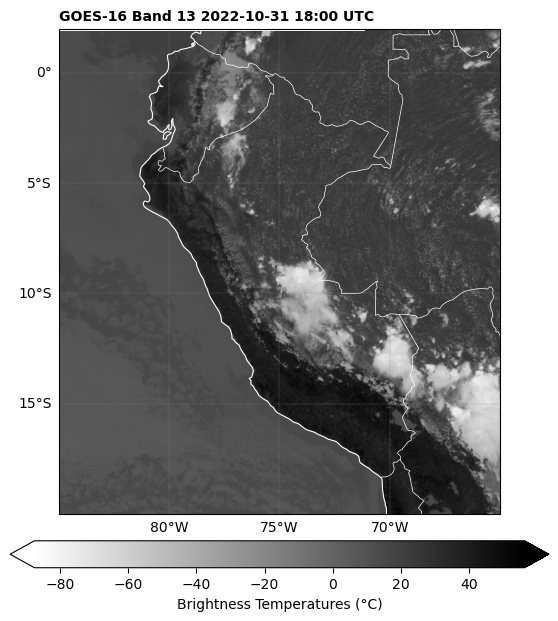

In [42]:
# Elijamos el tamaño de la figura (ancho x alto, en pulgadas)
plt.figure(figsize=(7,7))
 
# Usamos la proyección geoestacionaria en cartopy
ax = plt.axes(projection=ccrs.PlateCarree())
 
# Agregar líneas de costa, bordes y líneas de cuadrícula
ax.coastlines(color='white', linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, edgecolor='white', linewidth=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='gray', alpha=1.0, linestyle='--', 
linewidth=0.25, xlocs=np.arange(-180, 180, 5), ylocs=np.arange(-90, 90, 5), draw_labels=True)
gl.top_labels = False
gl.right_labels = False


# Define the color scale based on the channel
colormap = "gray_r" # White to black for IR channels

# Define the image extent
img_extent = [extent[0], extent[2], extent[1], extent[3]]

# Agregamos la matriz de datos
img = ax.imshow(data, origin='upper', extent=img_extent, cmap=colormap)

#img = ax.imshow(data, vmin=-80, vmax=40, origin='upper', extent=img_extent, cmap='Greys')

# Agregamos la barra de colores
plt.colorbar(img, label='Brightness Temperatures (°C)', extend='both', orientation='horizontal', pad=0.05, fraction=0.05)

# Extraemos la fecha
date = (datetime.strptime(dtime, '%Y-%m-%dT%H:%M:%S.%fZ'))
plt.title('GOES-16 Band 13 ' + date.strftime('%Y-%m-%d %H:%M') + ' UTC', fontweight='bold', fontsize=10, loc='left')


## Ahora vamos hacer nuestra figura con una paleta del [CPTEC](https://www.cptec.inpe.br/)

In [44]:
from utilities import loadCPT        # Import the CPT convert function
from matplotlib import cm            # Colormap handling utilities

In [45]:
cpt = loadCPT('IR4AVHRR6.cpt')                                    # Load the CPT file   
my_cmap4 = cm.colors.LinearSegmentedColormap('cpt', cpt)          # Create a custom linear colormap
vmin4 = -103.0                                                    # Min. value
vmax4 = 84.0                                                      # Max. value

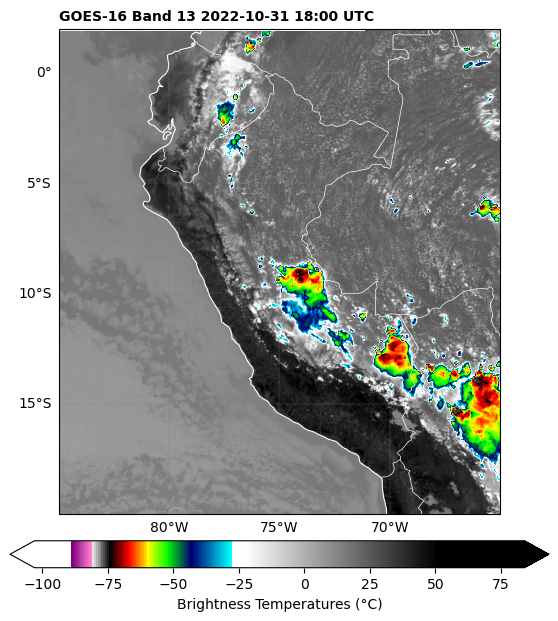

In [50]:
# Elijamos el tamaño de la figura (ancho x alto, en pulgadas)
fig = plt.figure(figsize=(7,7))
 
# Usamos la proyección geoestacionaria en cartopy
ax = plt.axes(projection=ccrs.PlateCarree())
 
# Agregar líneas de costa, bordes y líneas de cuadrícula
ax.coastlines(color='white', linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, edgecolor='white', linewidth=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='gray', alpha=1.0, linestyle='--', 
linewidth=0.25, xlocs=np.arange(-180, 180, 5), ylocs=np.arange(-90, 90, 5), draw_labels=True)
gl.top_labels = False
gl.right_labels = False


# Define the color scale based on the channel
colormap = "gray_r" # White to black for IR channels

# Define the image extent
img_extent = [extent[0], extent[2], extent[1], extent[3]]

# Agregamos la matriz de datos
img4 = ax.imshow(data, vmin=vmin4, vmax=vmax4, origin='upper', extent=img_extent, cmap=my_cmap4)

# Agregamos la barra de colores
plt.colorbar(img4, label='Brightness Temperatures (°C)', extend='both', orientation='horizontal', pad=0.05, fraction=0.05, ax=ax)

# Extraemos la fecha
date = (datetime.strptime(dtime, '%Y-%m-%dT%H:%M:%S.%fZ'))
plt.title('GOES-16 Band 13 ' + date.strftime('%Y-%m-%d %H:%M') + ' UTC', fontweight='bold', fontsize=10, loc='left')

fig.savefig('fig/GOES-16.png', dpi = 200, facecolor='w', bbox_inches = 'tight', 
            pad_inches = 0.1)


## Retornar al [indice](./../indice.md)